### Построение модели SARIMA для временного ряда ВВП России

In [1]:
import pandas as pd
import math as m
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
%pylab inline

/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/home/vladimir/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,0,'quarters')

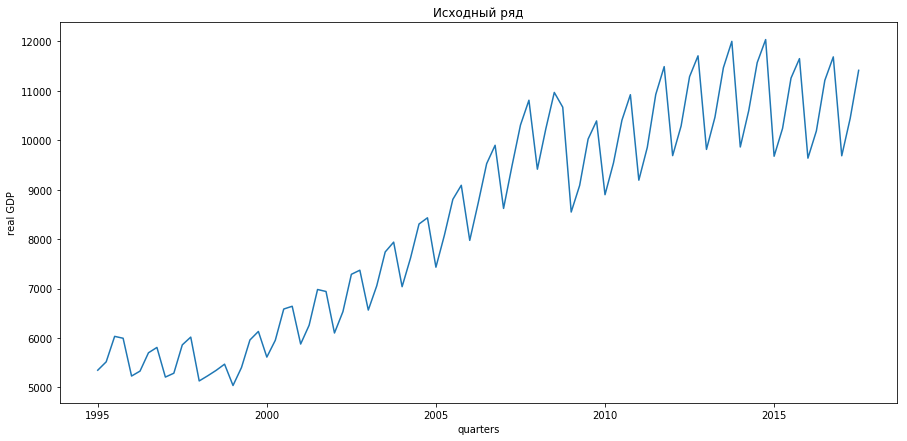

In [2]:
GDP = pd.read_csv("GDP.csv", index_col=['YEAR'], parse_dates=['YEAR'], dayfirst=True)
plt.figure(figsize(15,7))
plt.plot(GDP.GDP)
plt.title('Исходный ряд')
plt.ylabel('real GDP')
plt.xlabel('quarters')

In [3]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GDP.GDP)[1])

Критерий Дики-Фуллера: p=0.764802


Попытаемся Стабилизировать дисперсию с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.823587
Критерий Дики-Фуллера: p=0.749110


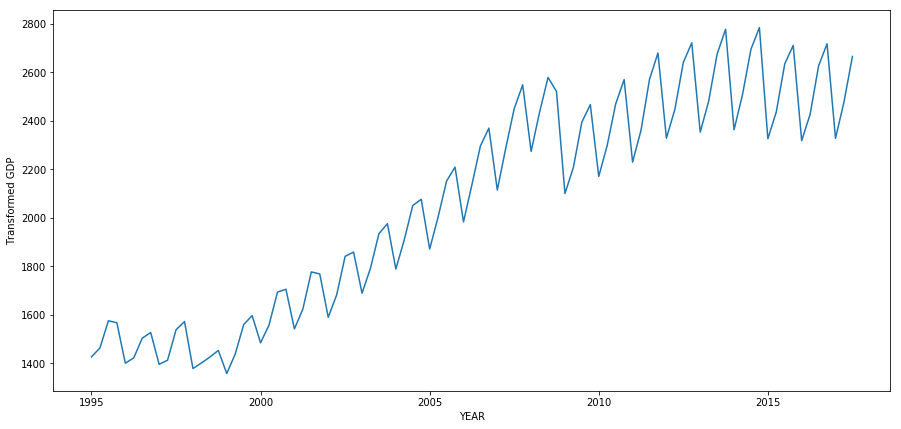

In [4]:
GDP['GDP_box'] , lmbda = stats.boxcox(GDP.GDP)
plt.figure(figsize(15,7))
GDP.GDP_box.plot()
plt.ylabel(u'Transformed GDP')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GDP.GDP_box)[1])

Попытаемся Сделать ряд стационарным с помощью сезонного дифференцирования

Критерий Дики-Фуллера: p=0.000543


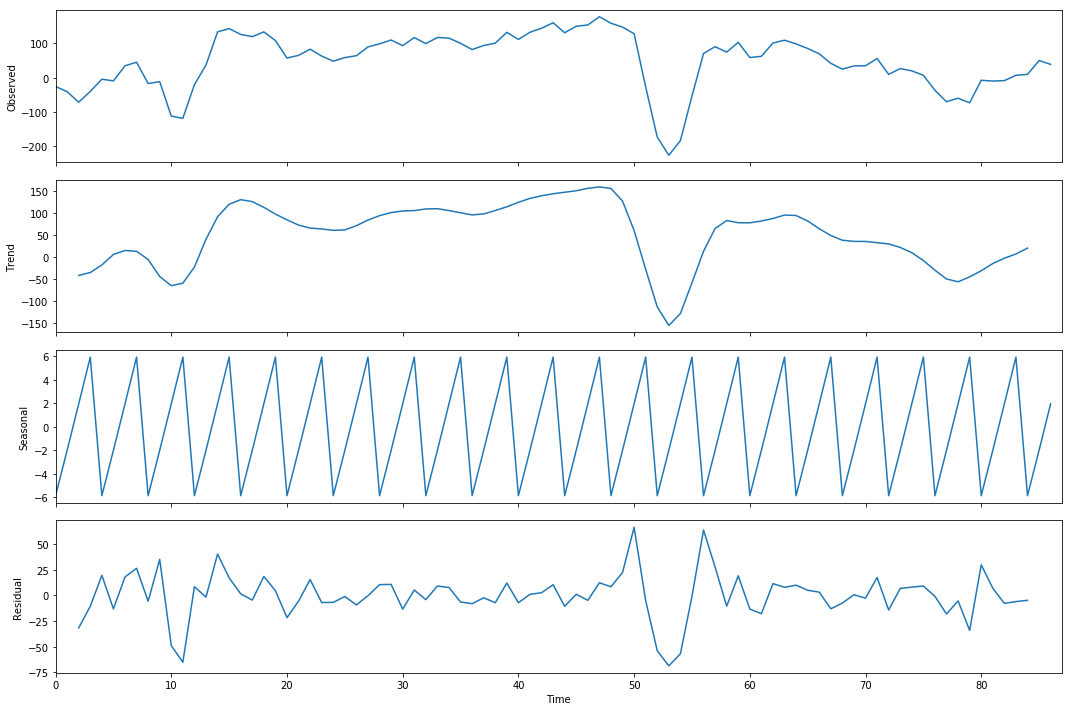

In [5]:
GDP['GDP_box_diff'] = GDP.GDP_box - GDP.GDP_box.shift(4)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(GDP.GDP_box_diff.values[4:], freq=4).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GDP.GDP_box_diff.values[4:])[1])

Гипотиза нестационарности отвергается, но по графику видно что ряд остался нестационарным

Критерий Дики-Фуллера: p=0.000000


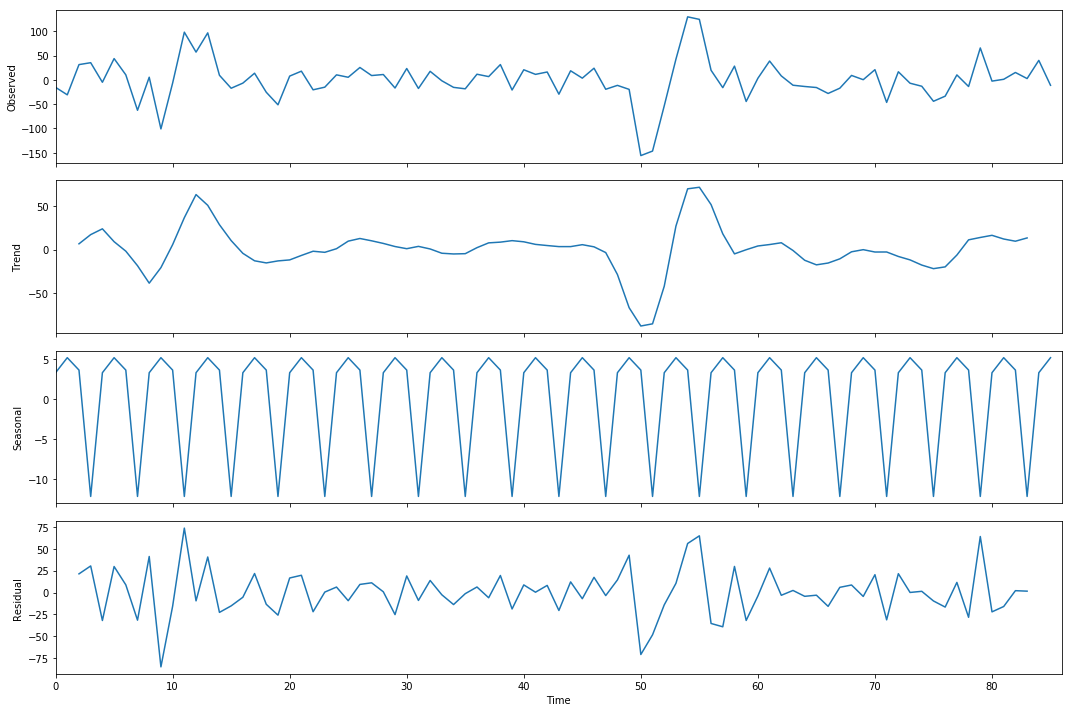

In [6]:
GDP['GDP_box_diff2'] = GDP.GDP_box_diff - GDP.GDP_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(GDP.GDP_box_diff2.values[5:], freq=4).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(GDP.GDP_box_diff2.values[5:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет(хотя виден странный перегиб в 2011 году, когда Росстат изменил способ рассчета ВВП).

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

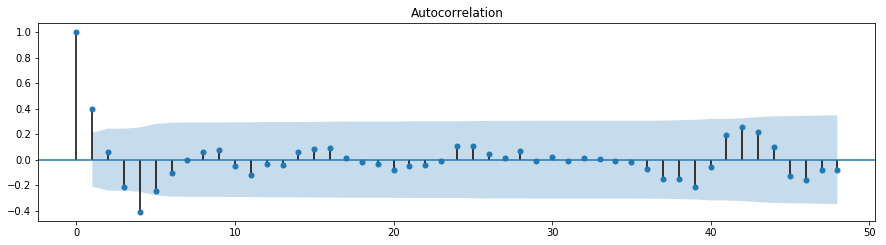

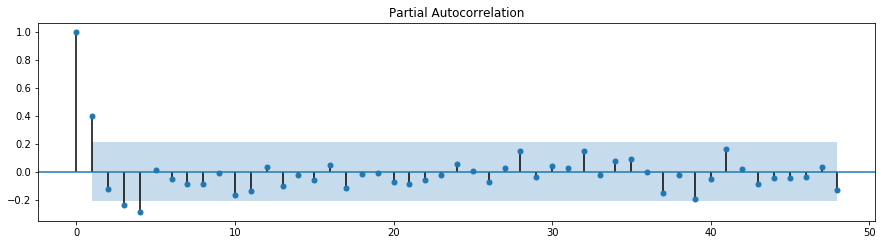

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(GDP.GDP_box_diff2.values[5:], lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(GDP.GDP_box_diff2.values[5:], lags=48, ax=ax)
pylab.show()

По автокорреляции мы будем подбирать начальное приближение для q и Q.
Максимальный сезонный лаг значимо отличающийся от 0 это лаг 4 -> За Q = 1 (так как переод сезонность 4)
q подбираем по несезонному лагу -> q = 2

p и P Подбираем по частичной автокорреляции.
Максимальный сезонный лаг значимо отличающийся от 0 это лаг 4 -> За P = 1 (так как переод сезонность 4)
p подбираем по несезонному лагу -> p = 2

Начальные приближения: P=1 p = 2 q = 2 Q = 2

In [33]:
from itertools import product
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [34]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(GDP.GDP_box.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
CPU times: user 10.1 s, sys: 248 ms, total: 10.3 s
Wall time: 2.82 s


In [39]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic').head())

      parameters         aic
13  (1, 0, 1, 0)  869.952421
12  (1, 0, 0, 1)  870.221684
4   (0, 1, 0, 1)  870.744410
5   (0, 1, 1, 0)  870.745724
9   (0, 2, 1, 0)  870.944839


Лучшая модель:

In [40]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   91
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                -431.976
Date:                           Thu, 22 Mar 2018   AIC                            869.952
Time:                                   10:04:48   BIC                            877.485
Sample:                                        0   HQIC                           872.991
                                            - 91                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3431      0.083      4.137      0.000       0.181       0.506
ar.S.L4       -0.3547      0.077     -4.628

Prob(Q) = 0.95 -> остатки модели не автокоррелированы

Рассмотрим остатки модели

Критерий Стьюдента: p=0.900692
Критерий Дики-Фуллера: p=0.000000


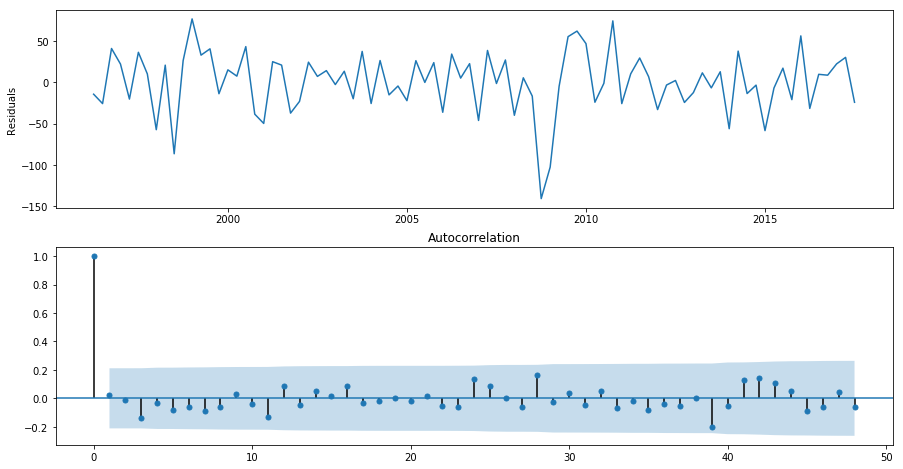

In [48]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(GDP.index.values[5:], best_model.resid[5:])
#best_model.resid[5:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[5:], lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[5:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[5:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

In [49]:
#В питоне почему-то нет функции обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

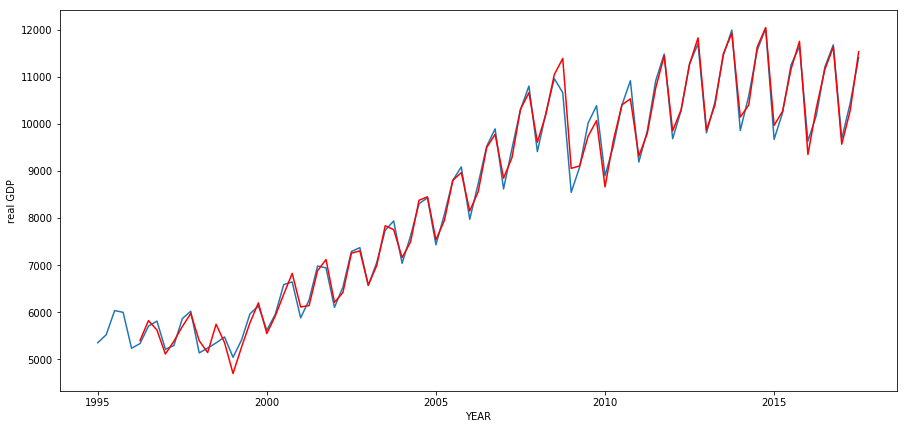

In [87]:
GDP['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
GDP.GDP.plot()
plt.plot(GDP.index.values[5:], GDP.model.values[5:], color='r')
#GDP.model[5:].plot(color='r')
plt.ylabel('real GDP')
pylab.show()

Видно что во врямя кризиса 2008 года, качество сильно упало.

### Прогноз

In [109]:
GDP2 = GDP[['GDP']]
date_list = np.linspace(2017.75, 2019.5,8)
future = pd.DataFrame(index=date_list, columns= GDP2.columns)
GDP2 = pd.concat([GDP2, future])
start = len(best_model.fittedvalues)
predict = best_model.predict(start=start, end=start+7)

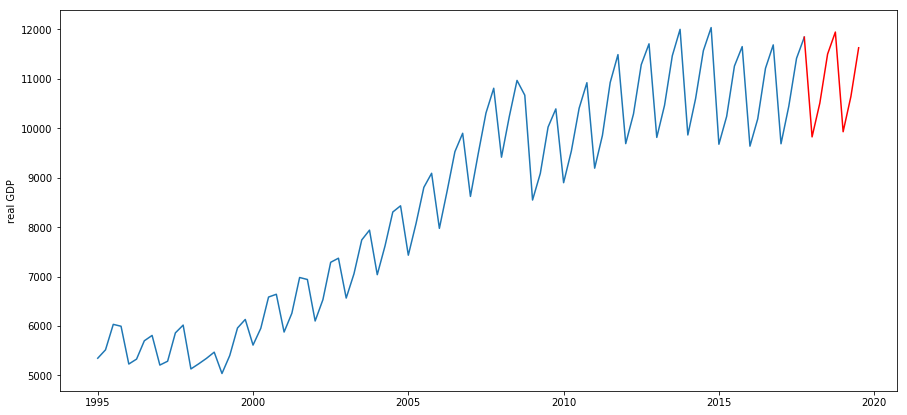

In [110]:
GDP2.GDP[2017.75:] = invboxcox(predict, lmbda)
plt.figure(figsize(15,7))
GDP2.GDP[:2017.75].plot()
GDP2.GDP[2017.75:].plot(color='r')
plt.ylabel('real GDP')
pylab.show()

Визуально, прогноз кажется адекватным, виден некоторый подъем